# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))


def get_json(archive_name, json_name):
    archive = zipfile.ZipFile(archive_name)
    return json.load(io.BytesIO(archive.read(json_name)))

In [2]:
def __compute_rank_mapping(archive_name, exp_id):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = get_json(archive_name, 'history.json')
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    mpirun = mpirun[exp_id]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket']
    return df.sort_values(by='rank').reset_index(drop=True)

def compute_rank_mapping(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    mappings = [__compute_rank_mapping(archive_name, i) for i in range(nb_exp)]
    ref = mappings[0]
    for df in mappings[1:]:
        assert ref.equals(df)
    return ref

In [3]:
archive = 'geometry/5/grenoble_2020-07-09_1939719.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df

traces = read_archive(archive, 0)

traces = traces[(traces['function'] == 'dgemm')].reset_index(drop=True)
for col in ['m', 'n', 'k', 'lda', 'ldb', 'ldc']:
    traces[col] = traces[col].astype(int)
print(len(traces))
traces.head()

Read trace n°0 from geometry/5/grenoble_2020-07-09_1939719.zip: 1996353 lines
1996353


,rank,jobid,function,start,end,m,n,k,lda,ldb,...,layout,transA,transB,duration,exp_id,hostname,socket,core,node,cpu
0,0,1939719,dgemm,0.000000,0.000843,249998,2,2,250000,128,...,102,111,112,0.000843,0,dahu-3.grenoble.grid5000.fr,0,0,3,6
1,0,1939719,dgemm,0.001884,0.003511,249996,4,4,250000,128,...,102,111,112,0.001626,0,dahu-3.grenoble.grid5000.fr,0,0,3,6
2,0,1939719,dgemm,0.004703,0.005522,249994,2,2,250000,128,...,102,111,112,0.000818,0,dahu-3.grenoble.grid5000.fr,0,0,3,6
3,0,1939719,dgemm,0.006360,0.009573,249992,8,8,250000,128,...,102,111,112,0.003214,0,dahu-3.grenoble.grid5000.fr,0,0,3,6
4,0,1939719,dgemm,0.010593,0.011428,249990,2,2,250000,128,...,102,111,112,0.000836,0,dahu-3.grenoble.grid5000.fr,0,0,3,6


## "In-depth" look at rank 0

Here we took the DGEMM trace of rank 0 and "replayed" it in a DGEMM calibration.

In [4]:
tmp = traces[traces['rank'] == 0]
print(tmp.duration.sum())
tmp[['function', 'm', 'n', 'k', 'lda', 'ldb', 'ldc']].to_csv('/tmp/exp.csv', index=False, header=False)
!head /tmp/exp.csv

917.889998269
dgemm,249998,2,2,250000,128,250000
dgemm,249996,4,4,250000,128,250000
dgemm,249994,2,2,250000,128,250000
dgemm,249992,8,8,250000,128,250000
dgemm,249990,2,2,250000,128,250000
dgemm,249988,4,4,250000,128,250000
dgemm,249986,2,2,250000,128,250000
dgemm,249984,16,16,250000,128,250000
dgemm,249982,2,2,250000,128,250000
dgemm,249980,4,4,250000,128,250000


For the record, the different numerical values for the arguments of dgemm are (according to my tests):
```
CblasColMajor: 102
CblasRowMajor: 101
CblasNoTrans : 111
CblasTrans   : 112
```

In [5]:
calibration_archive = 'dgemm_prediction/12/grenoble_2020-08-07_1943671.zip'
traces_calibration = read_csv(calibration_archive, 'result.csv')
print(list(sorted(traces_calibration['core'].unique())))
print(len(list(traces_calibration['core'].unique())))
tmp_calibration = traces_calibration[(traces_calibration['core'] == tmp['core'].unique()[0]) & (traces_calibration['hostname'] == tmp['hostname'].unique()[0])]
tmp_calibration = tmp_calibration.reset_index(drop=True)
print(len(tmp_calibration))
tmp_calibration.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
32
5030


,function,m,n,k,lda,ldb,ldc,timestamp,duration,core,hostname,jobid
0,dgemm,249998,2,2,250000,128,250000,1014.294020,0.000996,0,dahu-3.grenoble.grid5000.fr,1943671
1,dgemm,249996,4,4,250000,128,250000,1014.295048,0.001920,0,dahu-3.grenoble.grid5000.fr,1943671
2,dgemm,249994,2,2,250000,128,250000,1014.296977,0.000964,0,dahu-3.grenoble.grid5000.fr,1943671
3,dgemm,249992,8,8,250000,128,250000,1014.297947,0.003972,0,dahu-3.grenoble.grid5000.fr,1943671
4,dgemm,249990,2,2,250000,128,250000,1014.301928,0.000987,0,dahu-3.grenoble.grid5000.fr,1943671


In [6]:
sizelist_hpl = [list(t[1]) for t in tmp[['m', 'n', 'k']].iterrows()]
sizelist_cal = [list(t[1]) for t in tmp_calibration[['m', 'n', 'k']].iterrows()]
assert sizelist_hpl == sizelist_cal

In [7]:
tmp_calibration['start'] = tmp_calibration['timestamp']
tmp_calibration['end'] = tmp_calibration['start'] + tmp_calibration['duration']
tmp['duration_calibration'] = tmp_calibration['duration']
tmp['start_calibration'] = tmp_calibration['start']
tmp['end_calibration'] = tmp_calibration['end']
tmp['mnk'] = traces.m * traces.n * traces.k

In [8]:
dgemm_file = '/tmp/dgemm_generic_128.yaml'
!sha256sum $dgemm_file
with open(dgemm_file) as f:
    dgemm_model = yaml.load(f)

163aa21d41074673d6f6eaa22510d0f574ea46d8e1fa6316cf6000b9604037e7  /tmp/dgemm_generic_128.yaml


In [9]:
tmp.columns

Index(['rank', 'jobid', 'function', 'start', 'end', 'm', 'n', 'k', 'lda',
       'ldb', 'ldc', 'layout', 'transA', 'transB', 'duration', 'exp_id',
       'hostname', 'socket', 'core', 'node', 'cpu', 'duration_calibration',
       'start_calibration', 'end_calibration', 'mnk'],
      dtype='object')

In [10]:
import numpy

def compute_pred(df, model):
    df['raw_duration'] = -1
    df['noise_std'] = 0
    df['mnk'] = df['m'] * df['n'] * df['k']
    df['mn'] = df['m'] * df['n']
    df['mk'] = df['m'] * df['k']
    df['nk'] = df['n'] * df['k']
    for node in model['model']:
        df.loc[df['cpu_id'] == node['cpu_id'], 'raw_duration'] = node['intercept']
        for arg in ['mnk', 'mn', 'nk', 'mk']:
            df.loc[df['cpu_id'] == node['cpu_id'], 'raw_duration'] += node[arg] * df[arg]
        df.loc[df['cpu_id'] == node['cpu_id'], 'noise_std'] = node['intercept_residual']
        for arg in ['mnk', 'mn', 'nk', 'mk']:
            df.loc[df['cpu_id'] == node['cpu_id'], 'noise_std'] += node[f'{arg}_residual'] * df[arg]
    df.loc[df['raw_duration'] < 0, 'raw_duration'] = float('nan')
    df['sigma'] = df['noise_std'] / numpy.sqrt(1-2/numpy.pi)
    df['mu'] = df['raw_duration'] - df['sigma']*numpy.sqrt(2/numpy.pi)
    df['duration_sim'] = abs(numpy.random.normal(size=len(df))) * df['sigma'] + df['mu']
    df['raw_gflops'] = 2e-9*df['mnk'] / df['raw_duration']
    df['gflops_sim'] = 2e-9*df['mnk'] / df['duration_sim']
    df

In [11]:
tmp['cpu_id'] = tmp['cpu']
compute_pred(tmp, dgemm_model)

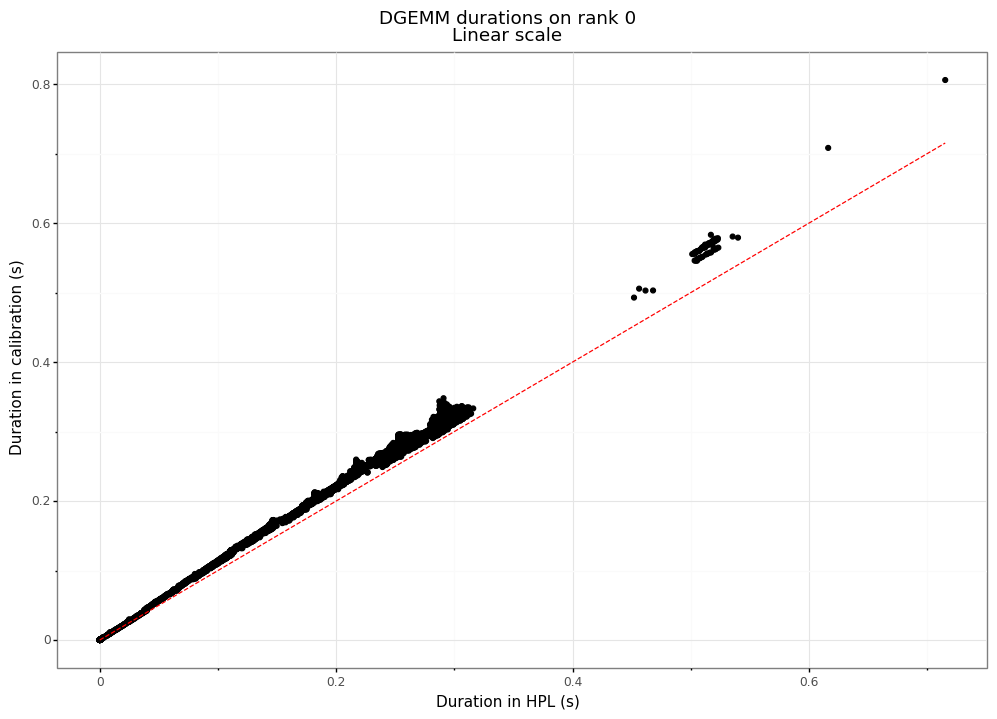

<ggplot: (8788443915752)>


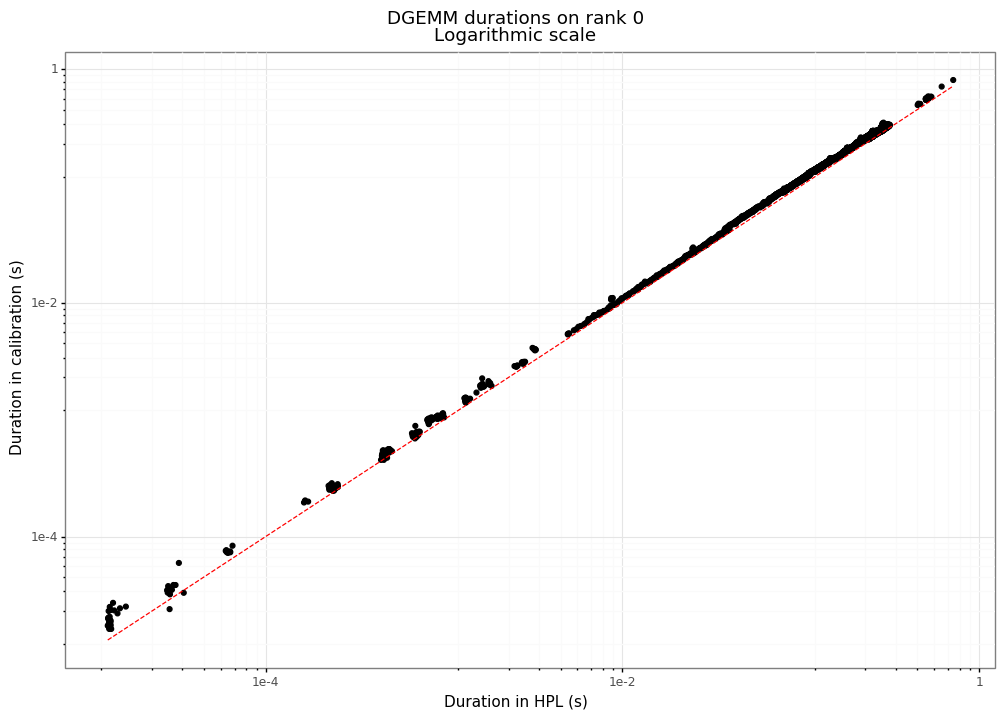

<ggplot: (-9223363248410870023)>


In [12]:
plot = ggplot(tmp, aes(x='duration', y='duration_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Duration in calibration (s)')
title = 'DGEMM durations on rank 0\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

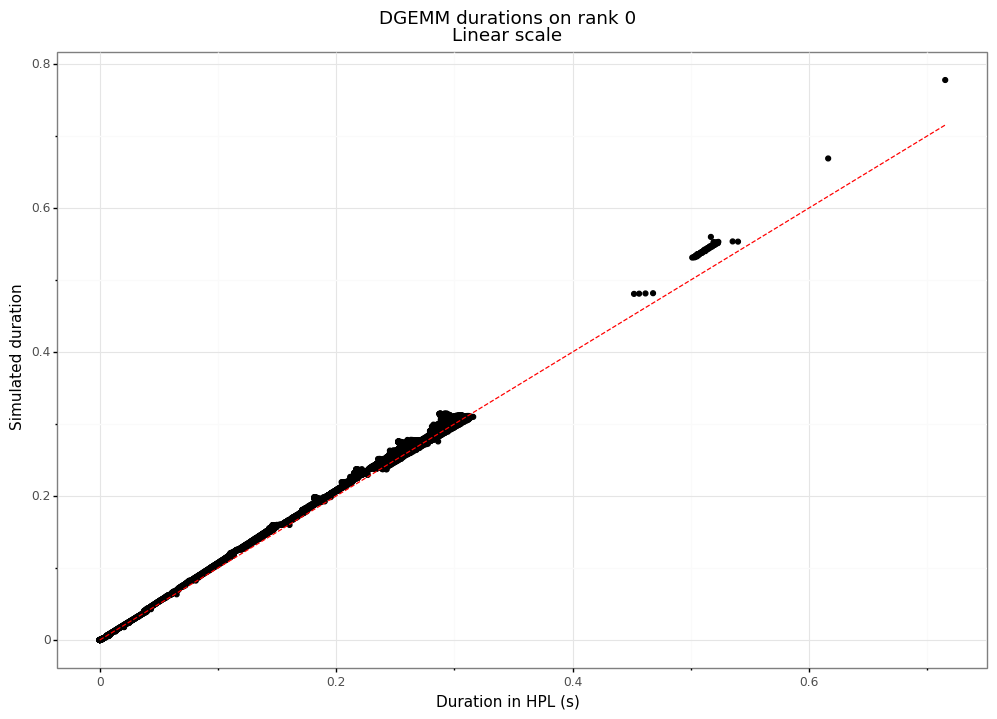

<ggplot: (8788443845615)>


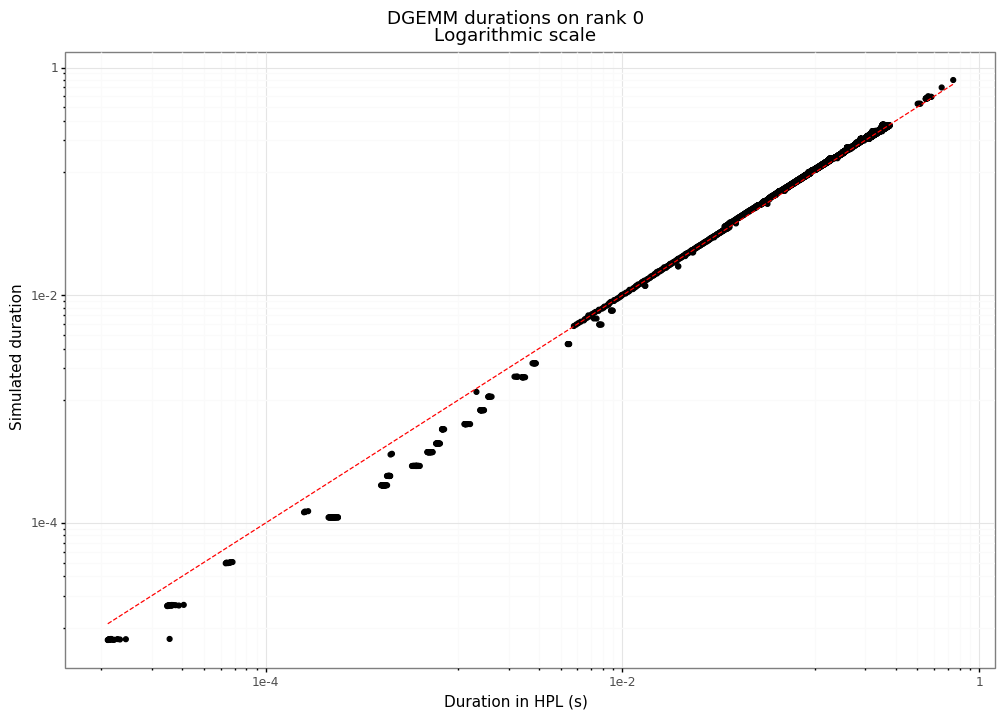

<ggplot: (-9223363248410931056)>


In [13]:
plot = ggplot(tmp, aes(x='duration', y='raw_duration')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Simulated duration')
title = 'DGEMM durations on rank 0\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

In [14]:
tmp['gflops_hpl'] = 2*tmp.mnk / tmp['duration'] * 1e-9
tmp['gflops_calibration'] = 2*tmp.mnk / tmp['duration_calibration'] * 1e-9

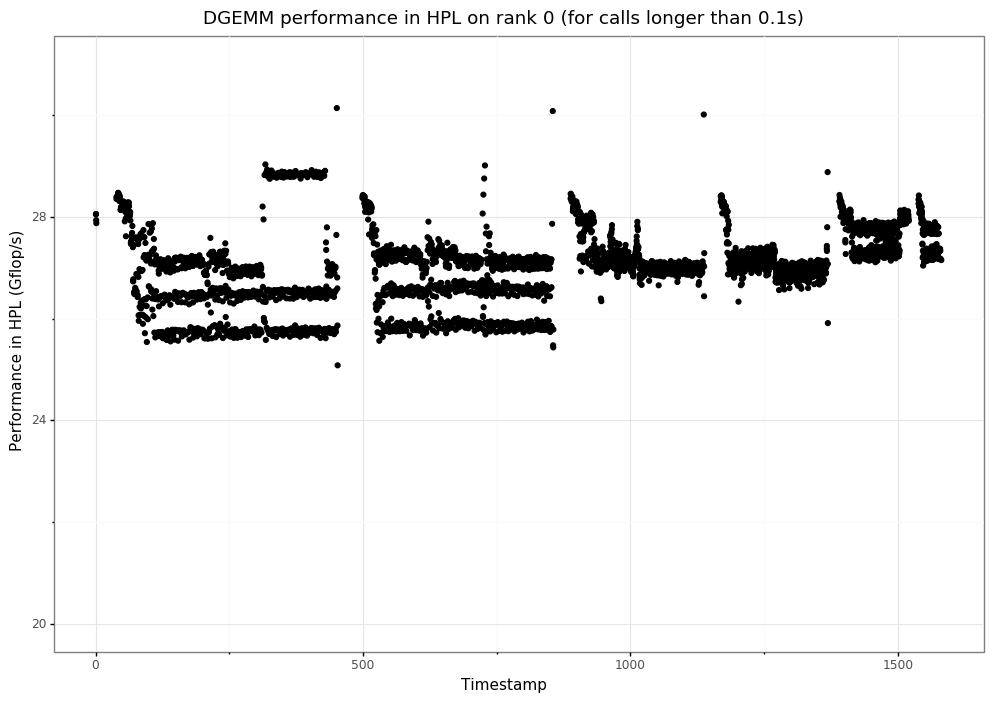

<ggplot: (-9223363248497822197)>

In [15]:
plot = ggplot(tmp[tmp.duration > 0.1], aes(x='start', y='gflops_hpl')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in HPL (Gflop/s)') + ggtitle('DGEMM performance in HPL on rank 0 (for calls longer than 0.1s)')
plot = plot + expand_limits(y=(20, 31))
plot

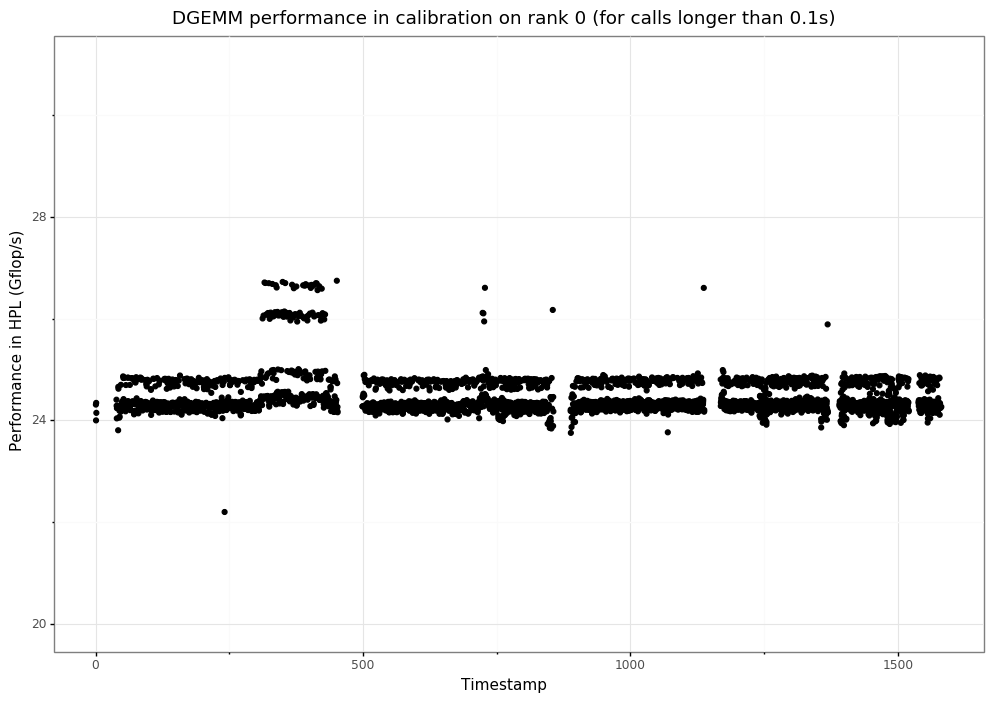

<ggplot: (-9223363248410966072)>

In [16]:
plot = ggplot(tmp[tmp.duration > 0.1], aes(x='start', y='gflops_calibration')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in HPL (Gflop/s)') + ggtitle('DGEMM performance in calibration on rank 0 (for calls longer than 0.1s)')
plot = plot + expand_limits(y=(20, 31))
plot

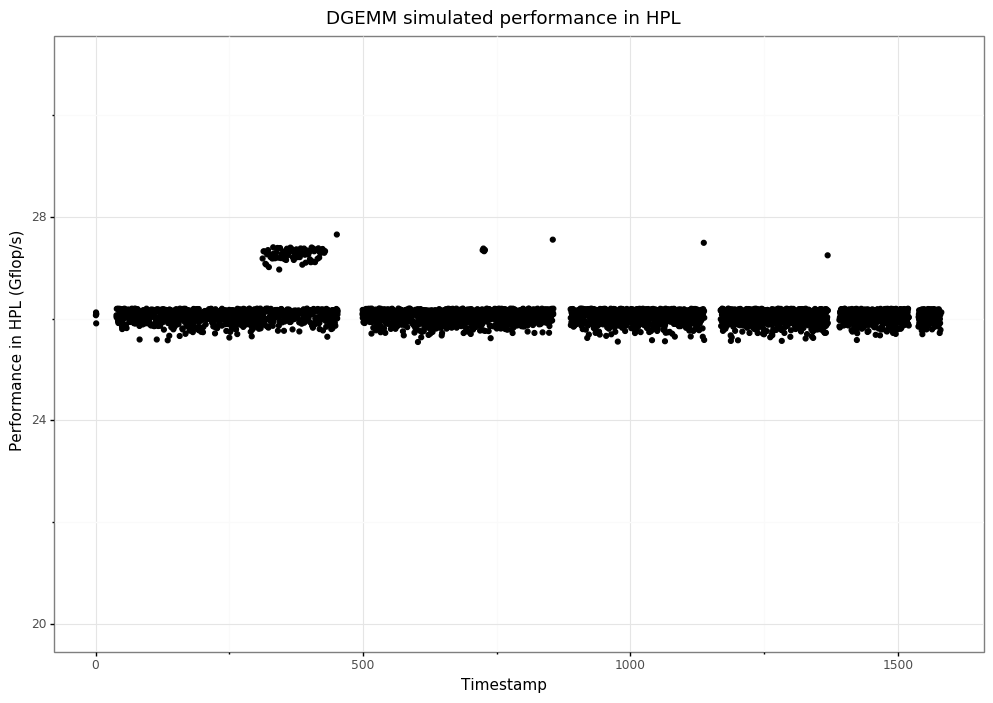

<ggplot: (-9223363248467780629)>

In [17]:
plot = ggplot(tmp[tmp.duration > 0.1], aes(x='start', y='gflops_sim')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in HPL (Gflop/s)') + ggtitle('DGEMM simulated performance in HPL')
plot = plot + expand_limits(y=(20, 31))
plot

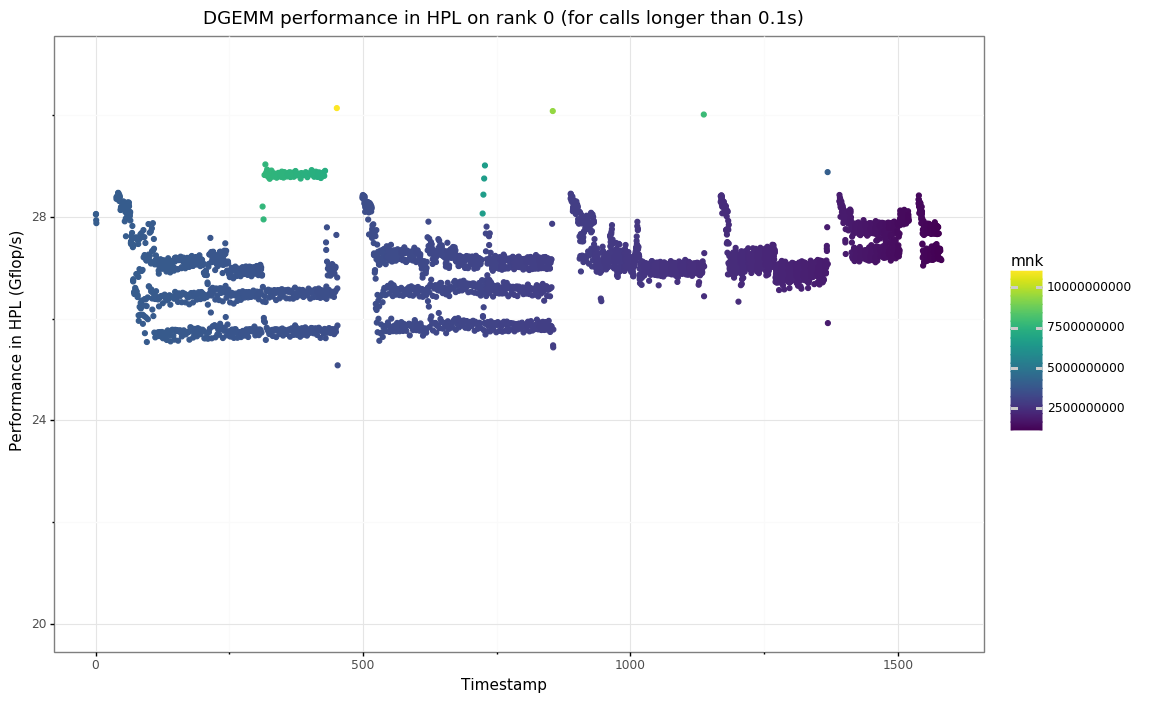

<ggplot: (-9223363248467819597)>

In [18]:
plot = ggplot(tmp[(tmp.duration > 0.1)], aes(x='start', y='gflops_hpl', color='mnk')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in HPL (Gflop/s)') + ggtitle('DGEMM performance in HPL on rank 0 (for calls longer than 0.1s)')
plot = plot + expand_limits(y=(20, 31))
plot

## Comparison of HPL DGEMM durations with the model

In [19]:
traces['cpu_id'] = traces['cpu']
compute_pred(traces, dgemm_model)
traces.head()

,rank,jobid,function,start,end,m,n,k,lda,ldb,...,noise_std,mnk,mn,mk,nk,sigma,mu,duration_sim,raw_gflops,gflops_sim
0,0,1939719,dgemm,0.000000,0.000843,249998,2,2,250000,128,...,0.000014,999992,499996,499996,4,0.000023,0.000401,0.000407,4.763013,4.908909
1,0,1939719,dgemm,0.001884,0.003511,249996,4,4,250000,128,...,0.000028,3999936,999984,999984,16,0.000046,0.000943,0.000986,8.162320,8.115962
2,0,1939719,dgemm,0.004703,0.005522,249994,2,2,250000,128,...,0.000014,999976,499988,499988,4,0.000023,0.000401,0.000424,4.763012,4.712367
3,0,1939719,dgemm,0.006360,0.009573,249992,8,8,250000,128,...,0.000057,15999488,1999936,1999936,64,0.000094,0.002454,0.002488,12.653227,12.861056
4,0,1939719,dgemm,0.010593,0.011428,249990,2,2,250000,128,...,0.000014,999960,499980,499980,4,0.000023,0.000401,0.000411,4.763012,4.867684


In [20]:
grouped = traces.groupby(['rank'])[['duration', 'duration_sim', 'mnk']].sum().reset_index()
grouped.head()

,rank,duration,duration_sim,mnk
0,0,917.889998,951.601915,12413132421120
1,1,928.293130,954.447033,12423530444800
2,2,925.354326,955.274921,12433917982720
3,3,925.219973,955.884028,12444295034880
4,4,926.522093,956.840282,12454661601280


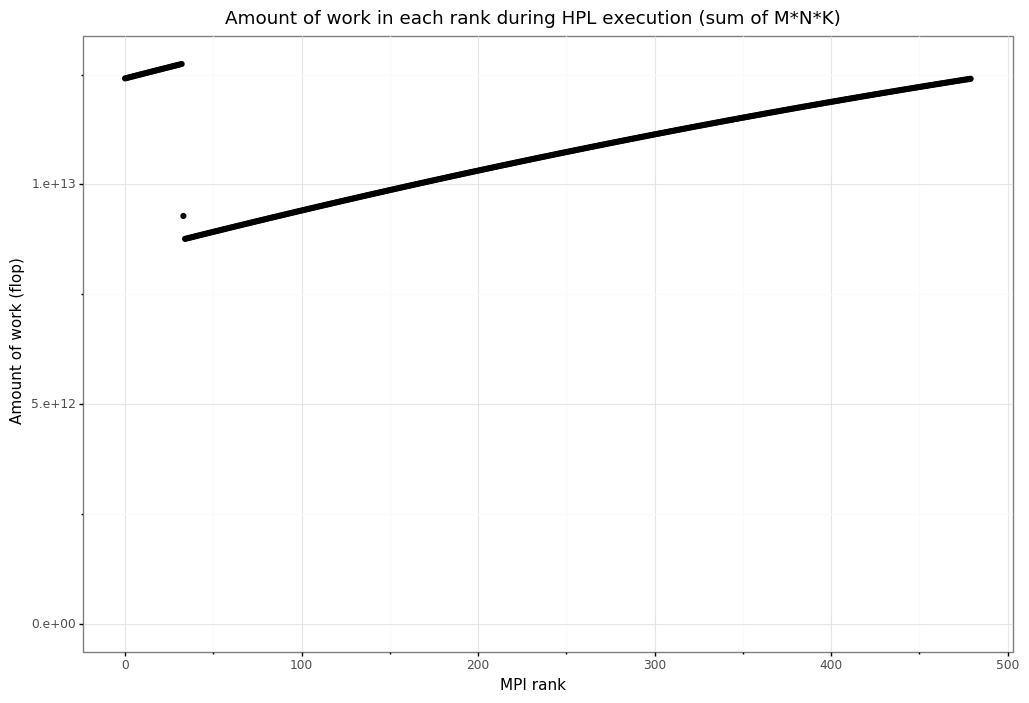

<ggplot: (8788386921245)>

In [21]:
from mizani.formatters import scientific_format

(ggplot(grouped)
    + aes(x='rank', y='mnk')
    + geom_point()
    + theme_bw()
    + ggtitle('Amount of work in each rank during HPL execution (sum of M*N*K)')
    + ylab('Amount of work (flop)')
    + xlab('MPI rank')
    + expand_limits(y=0)
    + scale_y_continuous(labels=scientific_format(digits=1))
)

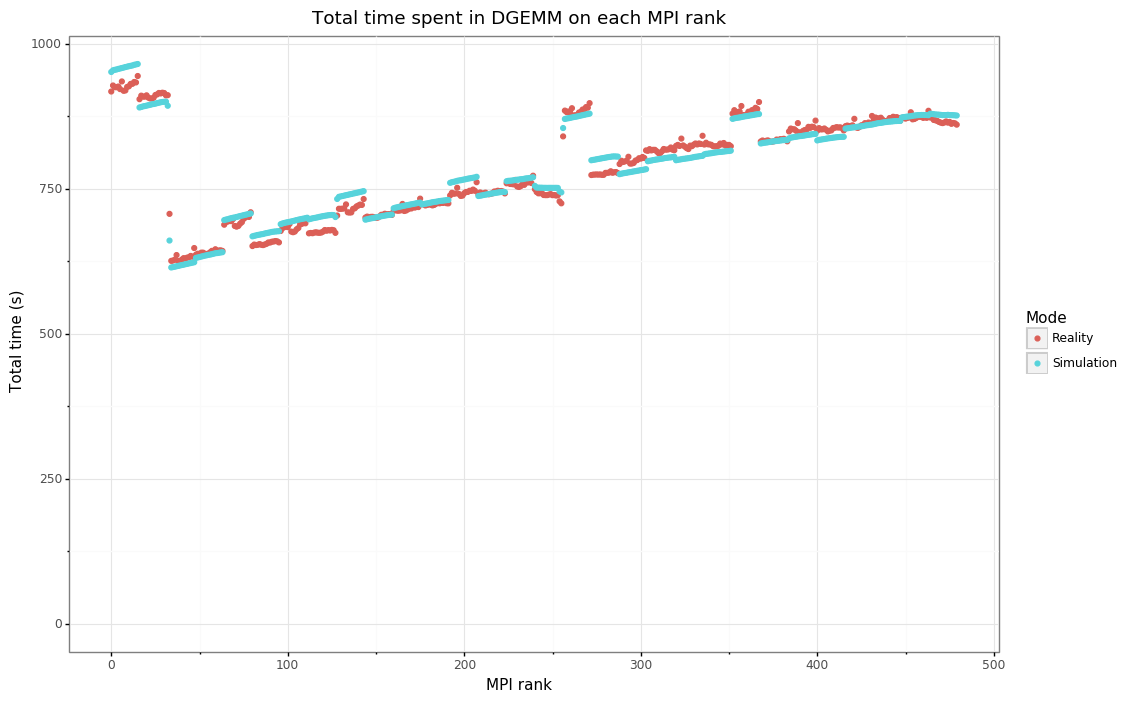

<ggplot: (-9223363248467854511)>

In [22]:
tmp = grouped.melt(id_vars=['rank', 'mnk'], value_vars=['duration', 'duration_sim'])
tmp.loc[tmp.variable == 'duration', 'variable'] = 'Reality'
tmp.loc[tmp.variable == 'duration_sim', 'variable'] = 'Simulation'
(ggplot(tmp)
    + aes(x='rank', y='value', color='variable')
    + geom_point()
    + theme_bw()
    + ggtitle('Total time spent in DGEMM on each MPI rank')
    + labs(x='MPI rank', y='Total time (s)', color='Mode')
    + expand_limits(y=0)
)

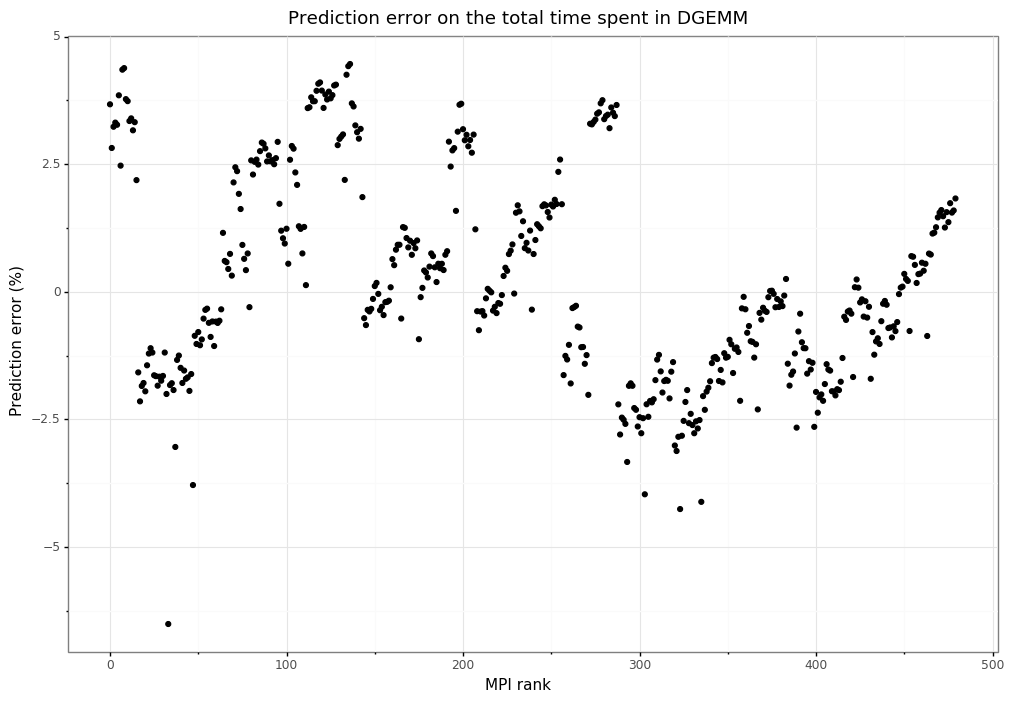

<ggplot: (8788386975941)>

In [23]:
grouped['error'] = (grouped['duration_sim'] / grouped['duration'] - 1) * 100
(ggplot(grouped)
    + aes(x='rank', y='error')
    + geom_point()
    + theme_bw()
    + ggtitle('Prediction error on the total time spent in DGEMM')
    + labs(x='MPI rank', y='Prediction error (%)', color='Mode')
    + expand_limits(y=0)
)

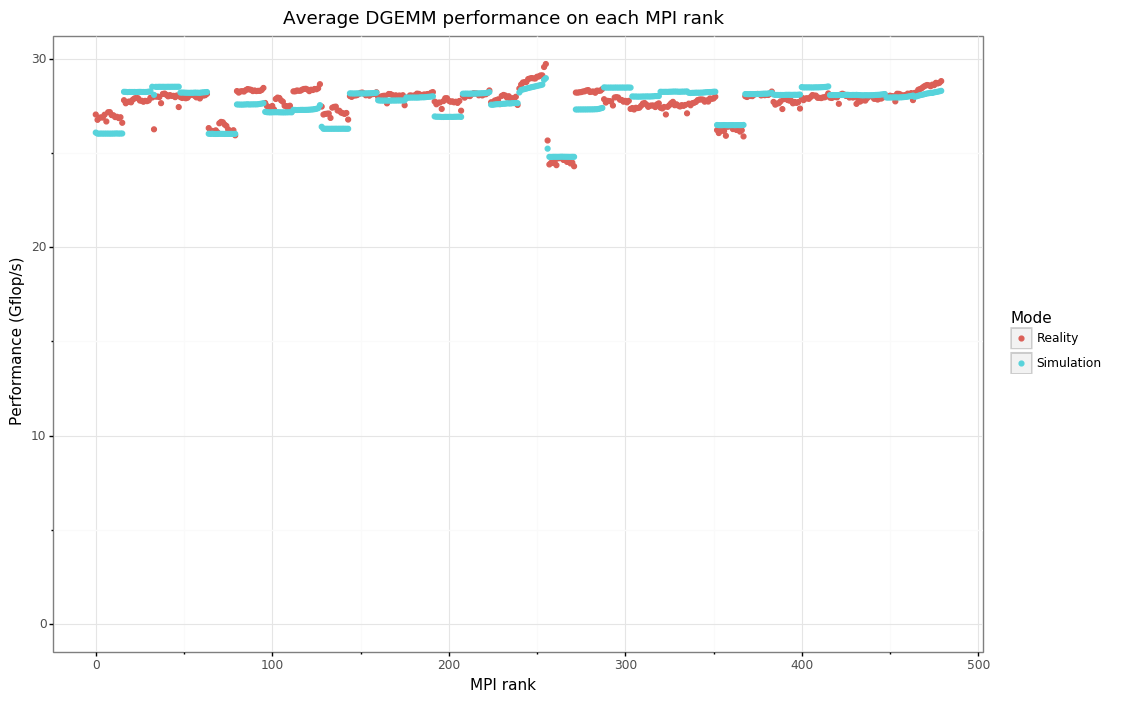

<ggplot: (8788386977060)>

In [24]:
tmp['gflops'] = 2e-9*tmp['mnk'] / tmp['value']
(ggplot(tmp)
    + aes(x='rank', y='gflops', color='variable')
    + geom_point()
    + theme_bw()
    + ggtitle('Average DGEMM performance on each MPI rank')
    + labs(x='MPI rank', y='Performance (Gflop/s)', color='Mode')
    + expand_limits(y=0)
)

## Computing a new model (using the HPL trace) and comparing it with the old one

In [25]:
import cashew
print(cashew.__git_version__)
from cashew import linear_regression as lr

c0a430e3a498fc690b6244ca9909444040c28128


In [26]:
traces['cluster'] = 'dahu'
traces['expfile_hash'] = '#'
traces['jobid'] = 42
traces['start_time'] = 42
model = lr.regression(traces, lr.compute_dgemm_reg)
for node in model:
    node['cpu_id'] = node['cpu']

In [27]:
traces['original_duration_sim'] = traces['duration_sim']
traces['original_gflops_sim'] = traces['gflops_sim']
compute_pred(traces, {'model': model})

In [28]:
tmp = traces.melt(id_vars=['rank', 'mnk'], value_vars=['duration', 'duration_sim', 'original_duration_sim'])
tmp.loc[tmp.variable == 'original_duration_sim', 'variable'] = 'Old model'
tmp.loc[tmp.variable == 'duration_sim', 'variable'] = 'New model'
tmp.loc[tmp.variable == 'duration', 'variable'] = 'Reality'

In [29]:
tmp.head()

,rank,mnk,variable,value
0,0,999992,Reality,0.000843
1,0,3999936,Reality,0.001626
2,0,999976,Reality,0.000818
3,0,15999488,Reality,0.003214
4,0,999960,Reality,0.000836


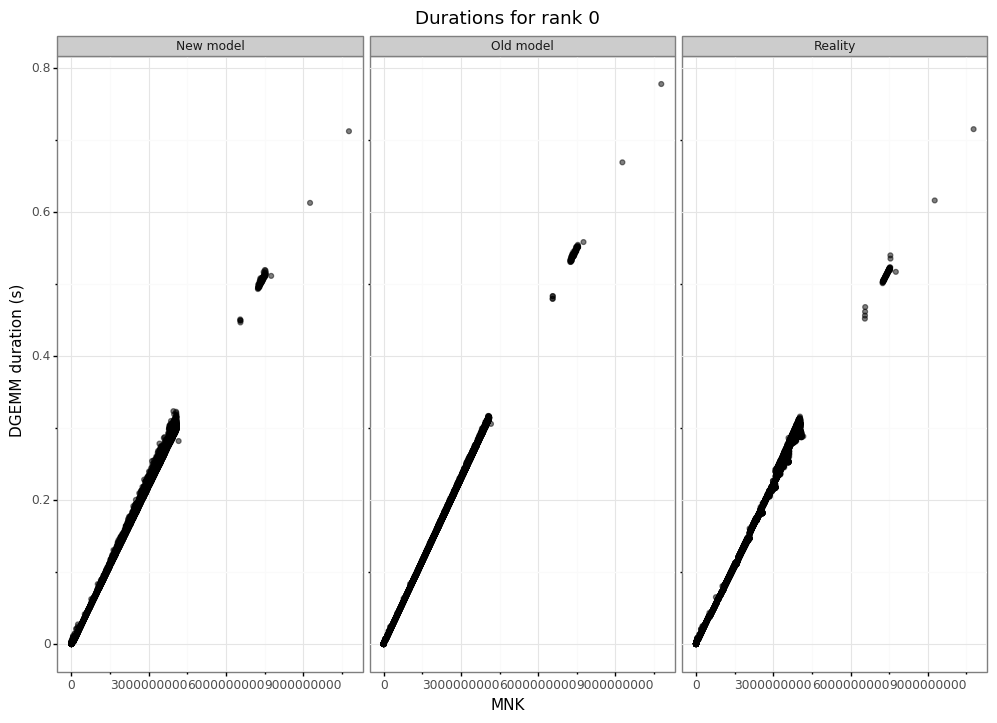

<ggplot: (-9223363248467797055)>


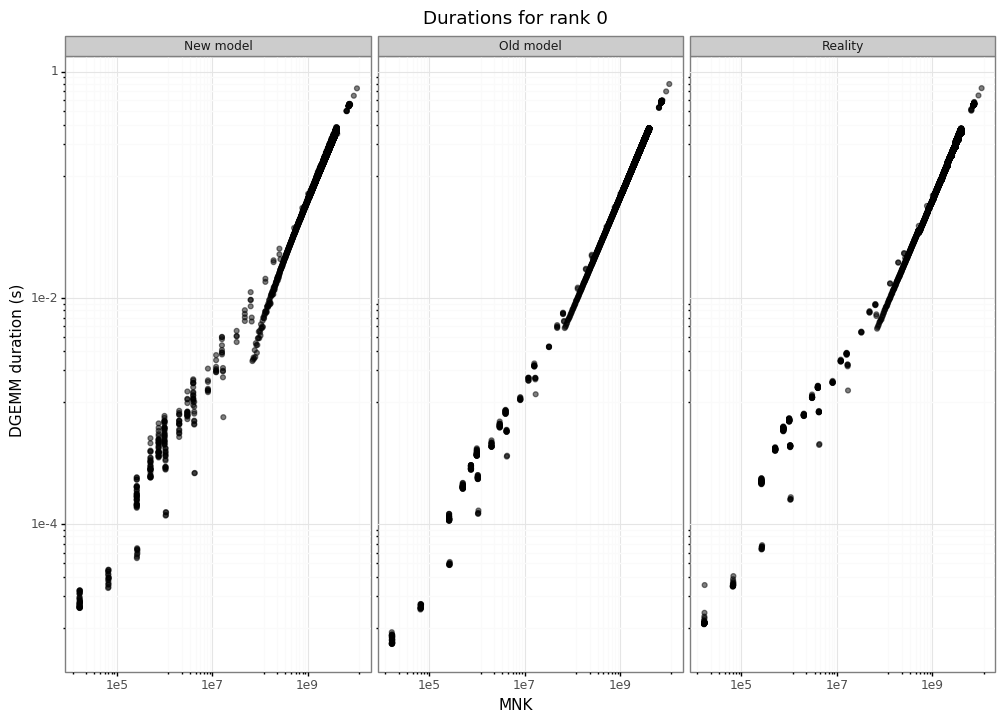

<ggplot: (8788386977330)>


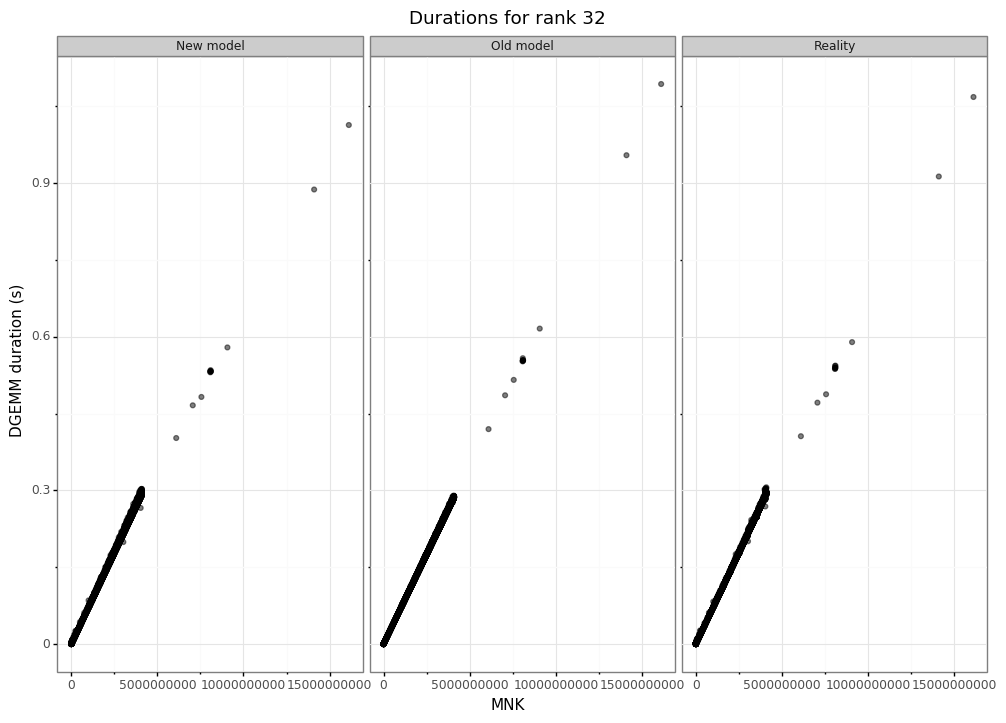

<ggplot: (-9223363248410896303)>


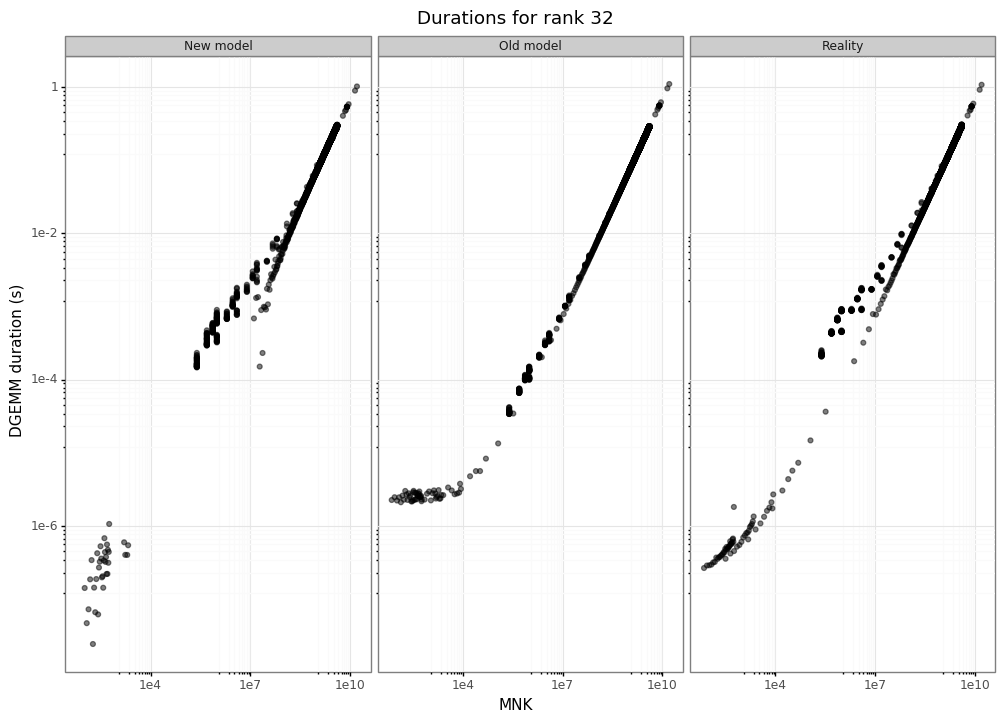

<ggplot: (-9223363248467793043)>


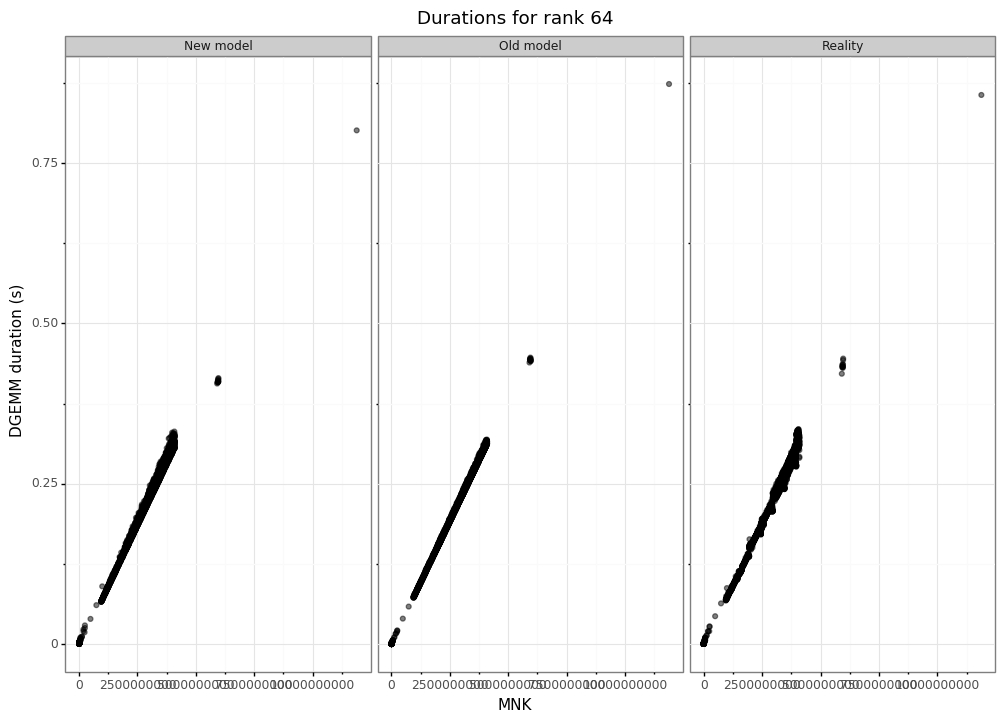

<ggplot: (8788375181046)>


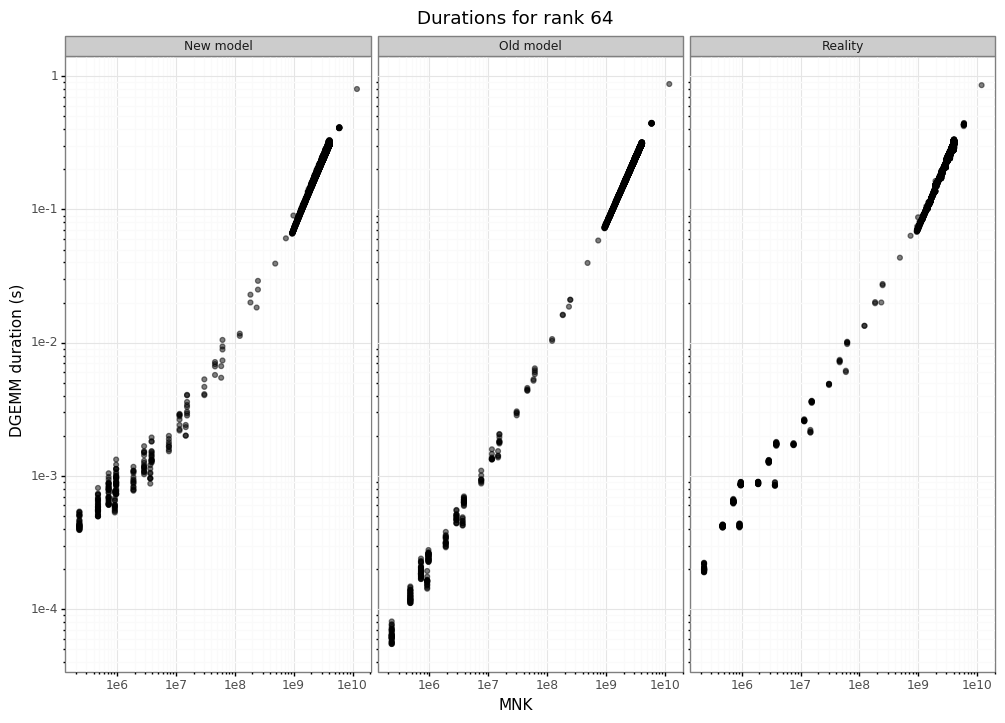

<ggplot: (-9223363248467849121)>


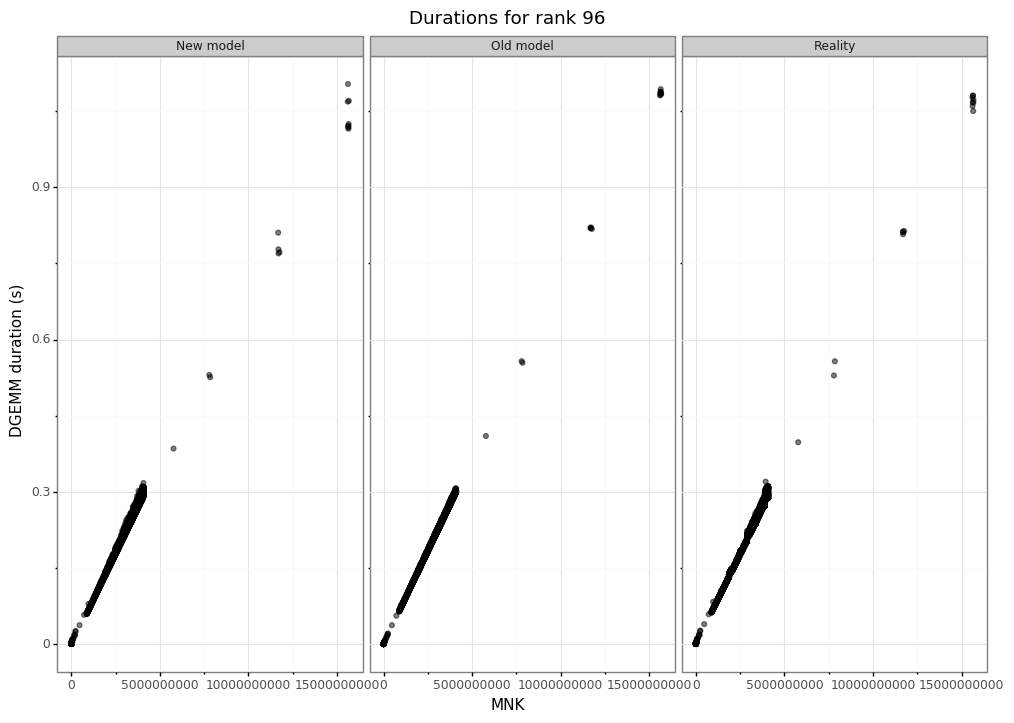

<ggplot: (-9223363248479744901)>


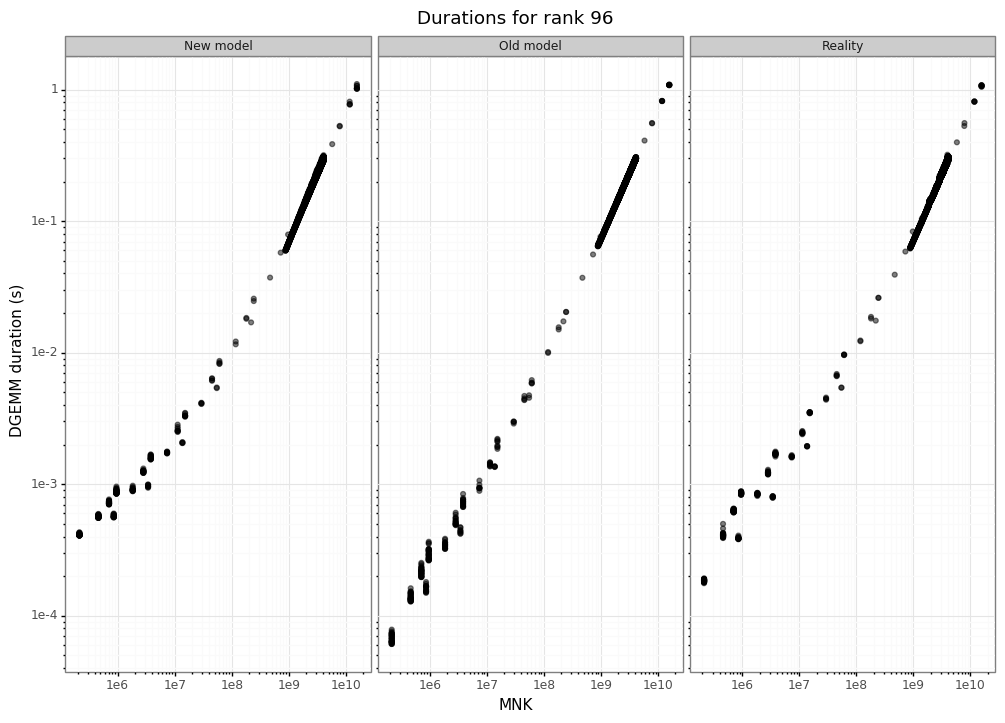

<ggplot: (8788374871023)>


In [30]:
for rank in [0, 32, 64, 96]:
    plot = (ggplot(tmp[tmp['rank'] == rank])
        + aes(x='mnk')
        + geom_point(aes(y='value'), alpha=0.5)
        + facet_wrap('variable')
        + theme_bw()
        + ggtitle(f'Durations for rank {rank}')
        + labs(x='MNK', y='DGEMM duration (s)')
    )
    print(plot)
    print(plot + scale_x_log10() + scale_y_log10())

In the next cell, we dump the new model in a yaml file.

In [31]:
import datetime
import copy

tmp = copy.deepcopy(model)
for node in tmp:
    for col in ['cluster', 'function', 'expfile_hash', 'cpu', 'start_time', 'jobid']:
        del node[col]
    for col in node.keys():
        if col in {'node', 'cpu_id'}:
            node[col] = int(node[col])
        else:
            node[col] = float(node[col])

dump_model = {'model': tmp}
dump_model['metadata'] = {
    'granularity': 'cpu',
    'archive_file': archive,
    'cashew_git': cashew.__git_version__,
    'file_creation_date': str(datetime.datetime.now()),
    'comment': 'Model generated with a DGEMM trace from an HPL run'
}
dump_model['info'] = {
    'cluster': 'dahu',
    'function': 'dgemm',
    'experiment_date': str(datetime.datetime.fromtimestamp(get_yaml(archive, 'oarstat.yaml')['startTime'])),
    'jobid': get_yaml(archive, 'oarstat.yaml')['Job_Id'],
}
avg_alpha = numpy.mean([tmp['mnk'] for tmp in model])
avg_beta  = numpy.mean([tmp['intercept'] for tmp in model])
var_coeff = numpy.mean([tmp['mnk_residual']/tmp['mnk'] for tmp in model])
het_coeff = numpy.std([tmp['mnk'] for tmp in model]) / avg_alpha
dump_model['info'].update({
    'avg_gflops': float(2e-9/avg_alpha),
    'avg_latency': float(avg_beta),
    'heterogeneity_coefficient': float(het_coeff),
    'variability_coefficient': float(var_coeff),
    'nb_nodes': len({tmp['node'] for tmp in model}),
    })


with open('/tmp/dgemm_hpl_model.yaml', 'w') as f:
    yaml.dump(dump_model, f)

## Monitoring

In [32]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [33]:
archives = [('calibration', calibration_archive), ('HPL', archive)]

In [34]:
dataframes = []
for mode, filename in archives:
    tmp = archive_extraction.read_monitoring(filename)
    tmp['expfile'] = archive_extraction.read_yaml(filename, 'info.yaml')['expfile'][0]
    tmp['mode'] = mode
    dataframes.append(tmp)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

1218112


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile,mode,date,real_start_time,cpu_id,in_exp,hostname
0,0.001279,dahu,1,1943671,1596803827,d55ffd563683cf068655984003fa02586f5694f0568e70...,1.000140,0,0,frequency,676.998383,3962.238379,exp_trace.csv,calibration,2020-08-07 12:37:07,1.596811e+09,1:0,False,dahu-1
1,10.019475,dahu,1,1943671,1596803827,d55ffd563683cf068655984003fa02586f5694f0568e70...,1.000140,0,0,frequency,676.998383,3962.238379,exp_trace.csv,calibration,2020-08-07 12:37:07,1.596811e+09,1:0,False,dahu-1
2,20.034825,dahu,1,1943671,1596803827,d55ffd563683cf068655984003fa02586f5694f0568e70...,2.520794,0,0,frequency,676.998383,3962.238379,exp_trace.csv,calibration,2020-08-07 12:37:07,1.596811e+09,1:0,False,dahu-1
3,30.057637,dahu,1,1943671,1596803827,d55ffd563683cf068655984003fa02586f5694f0568e70...,1.000268,0,0,frequency,676.998383,3962.238379,exp_trace.csv,calibration,2020-08-07 12:37:07,1.596811e+09,1:0,False,dahu-1
4,40.076109,dahu,1,1943671,1596803827,d55ffd563683cf068655984003fa02586f5694f0568e70...,2.585009,0,0,frequency,676.998383,3962.238379,exp_trace.csv,calibration,2020-08-07 12:37:07,1.596811e+09,1:0,False,dahu-1


In [35]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind', 'expfile', 'mode'])[['value']].mean().reset_index()
grouped_mon.head()

,node,cpu,cpu_id,kind,expfile,mode,value
0,1,0,1:0,frequency,exp_trace.csv,calibration,2.065160
1,1,0,1:0,temperature,exp_trace.csv,calibration,75.157041
2,1,1,1:1,frequency,exp_trace.csv,calibration,2.232012
3,1,1,1:1,temperature,exp_trace.csv,calibration,61.892207
4,2,0,2:0,frequency,exp_trace.csv,calibration,2.113707


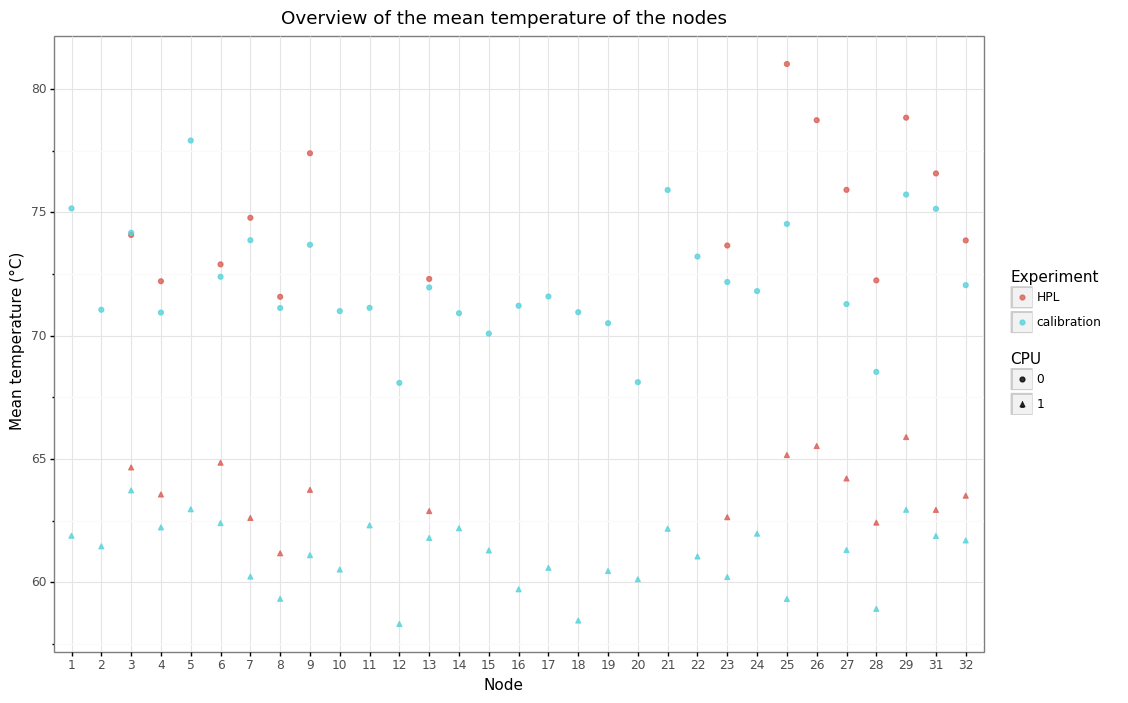

<ggplot: (8788287878720)>

In [36]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='factor(node)', y='value', color='mode', shape='factor(cpu)')
    + geom_point(alpha=0.8)
    + theme_bw()
    + labs(x='Node', y='Mean temperature (°C)', color='Experiment', shape='CPU')
    + ggtitle('Overview of the mean temperature of the nodes')
)

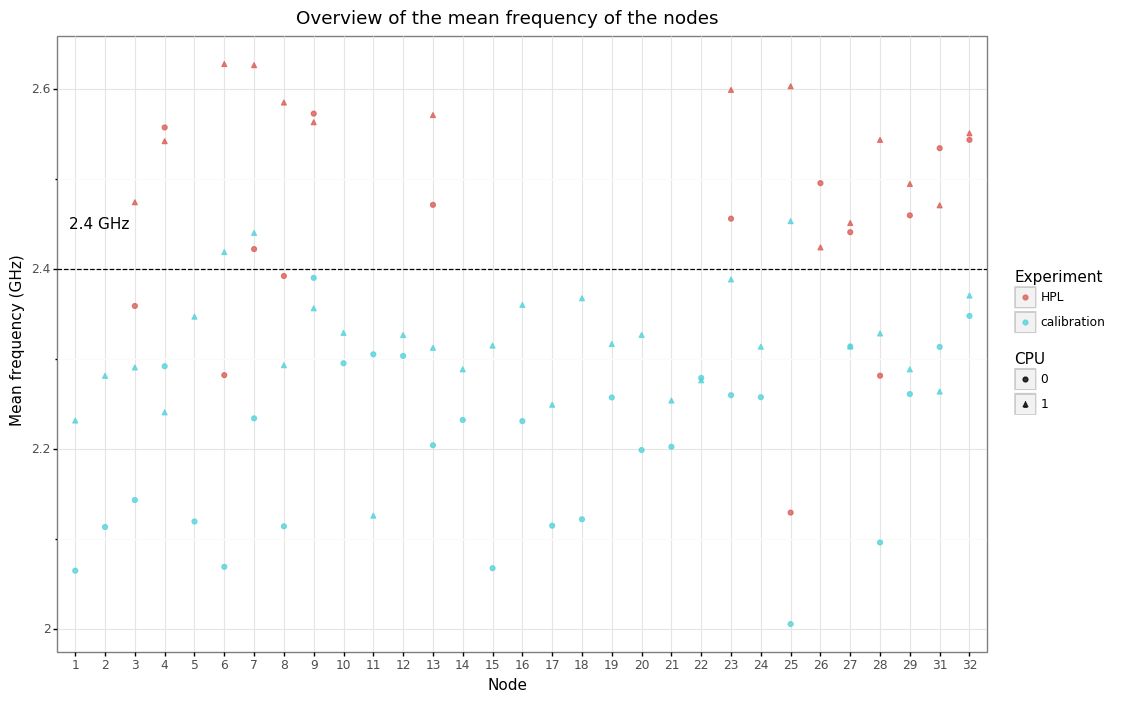

<ggplot: (-9223363248410870114)>

In [37]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='factor(node)', y='value', color='mode', shape='factor(cpu)')
    + geom_point(alpha=0.8)
    + theme_bw()
    + labs(x='Node', y='Mean frequency (GHz)', color='Experiment', shape='CPU')
    + ggtitle('Overview of the mean frequency of the nodes')
    + geom_hline(yintercept=2.4, linetype='dashed')
    + annotate('text', label='2.4 GHz', x=1.8, y=2.45)
)

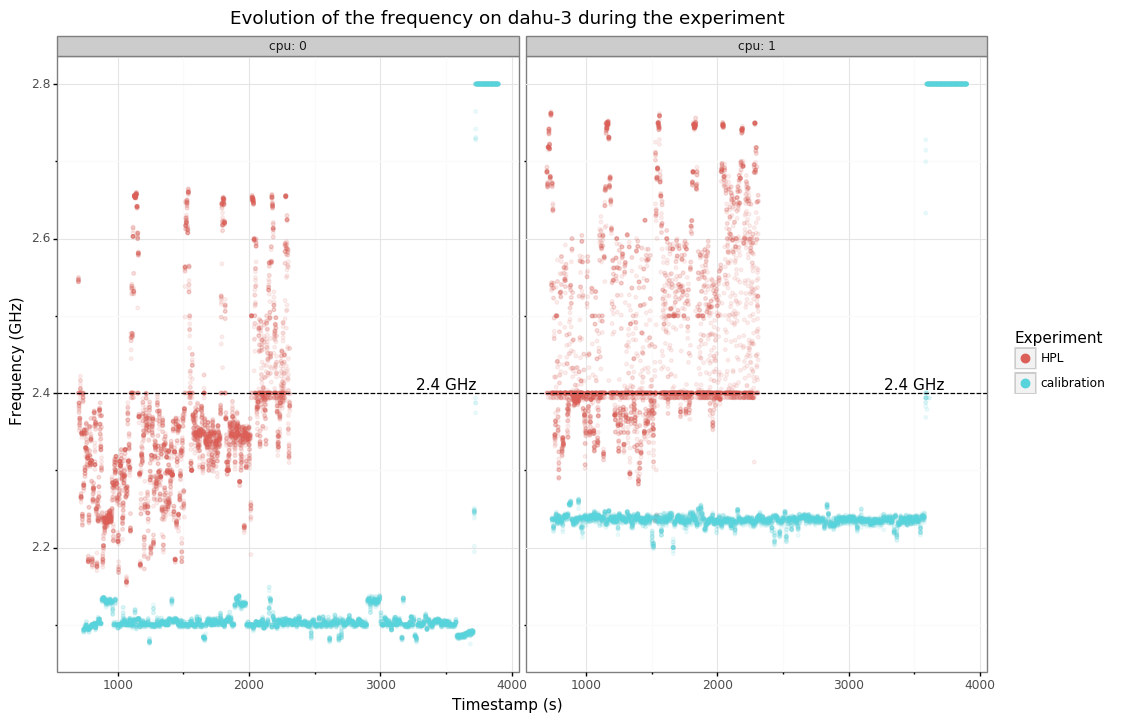

<ggplot: (-9223363248479931918)>


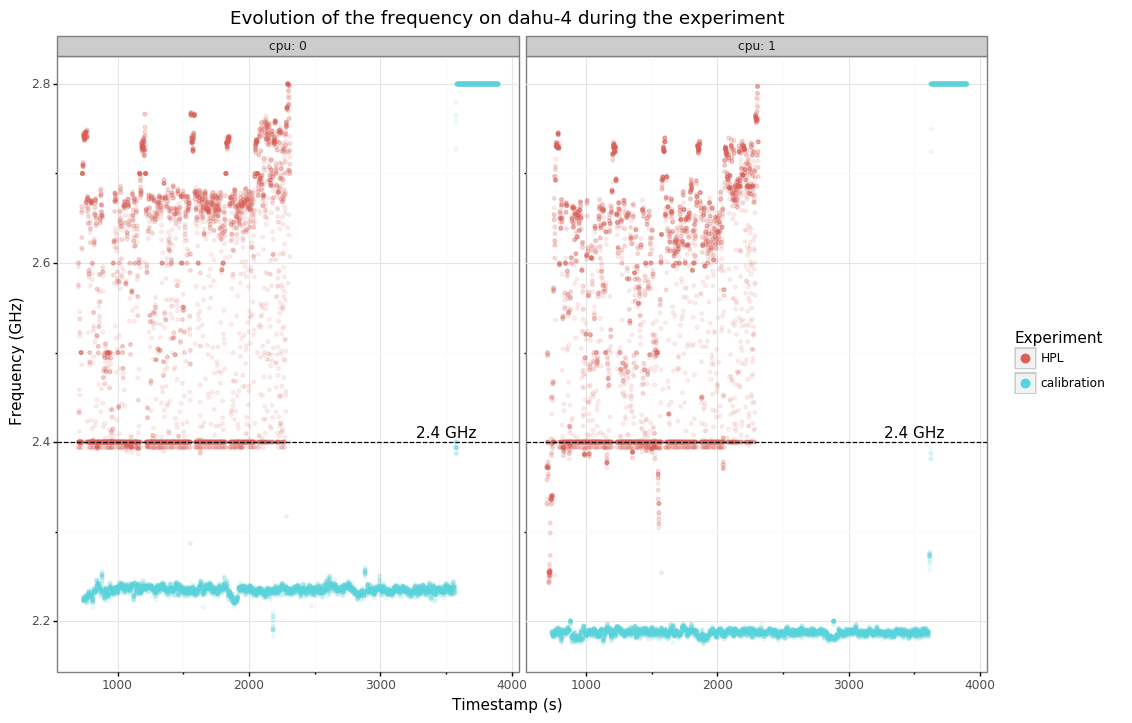

<ggplot: (8788295098351)>


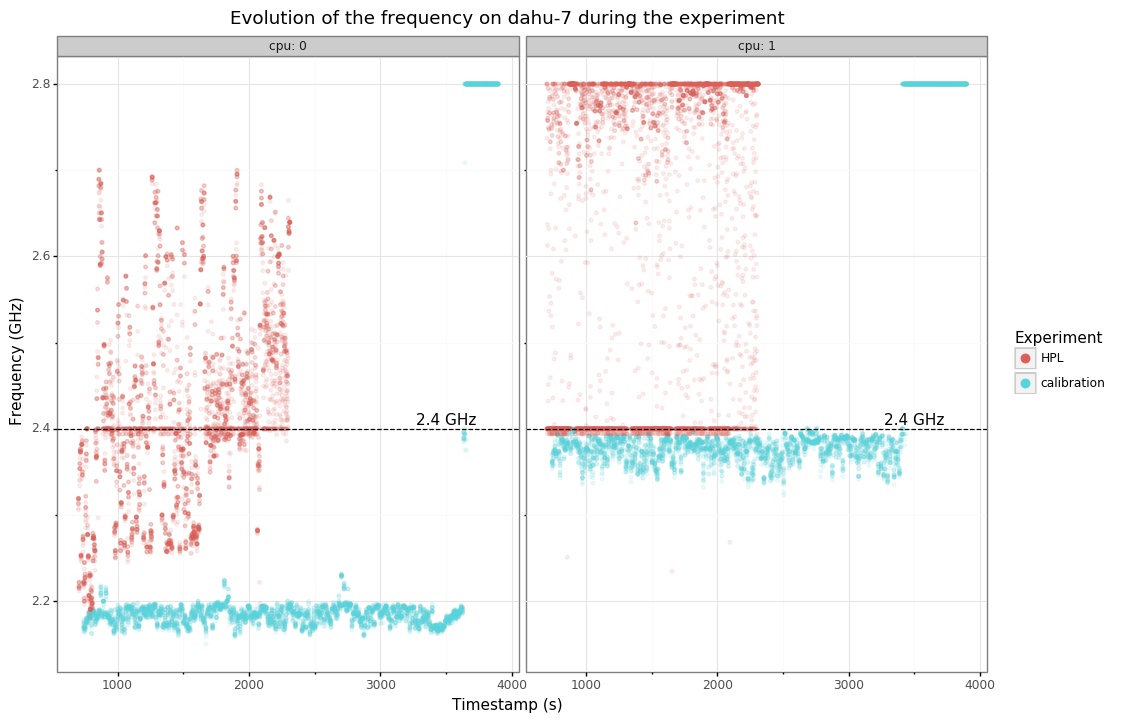

<ggplot: (-9223363248559942968)>


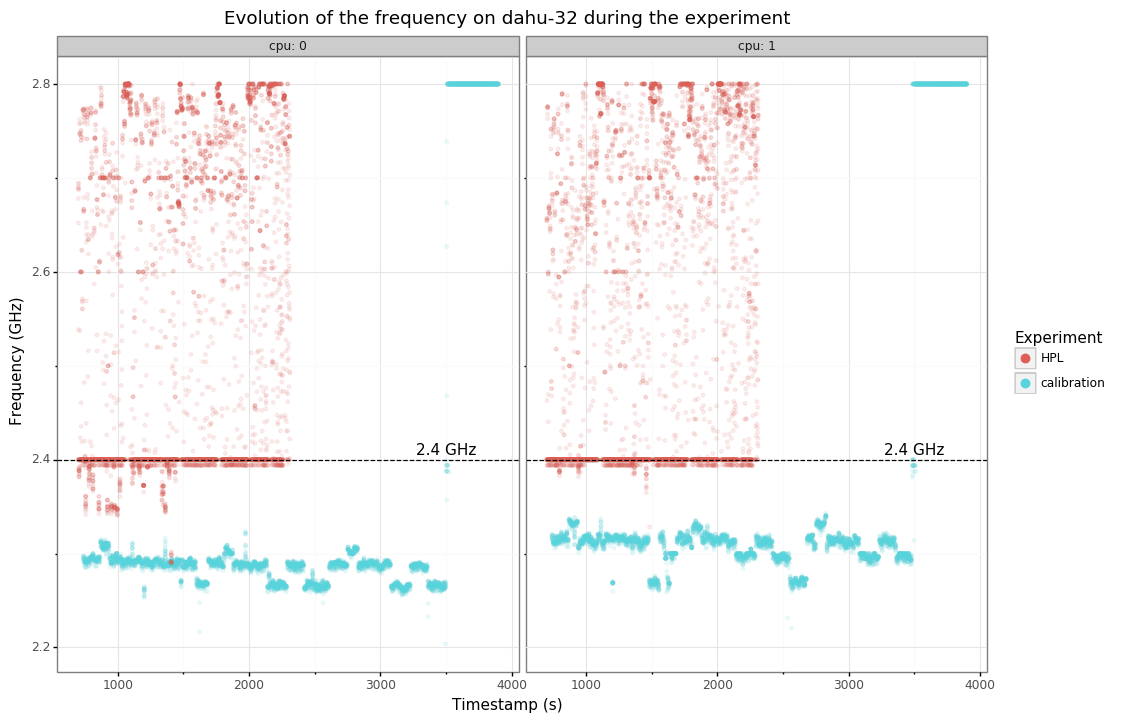

<ggplot: (-9223363248560325530)>


In [38]:
for node in [3,4,7,32]:
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.node == node) & (monitoring.kind == 'frequency')])
        + aes(x='timestamp', y='value', color='mode')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + facet_wrap('cpu', labeller='label_both')
        + labs(x='Timestamp (s)', y='Frequency (GHz)', color='Experiment')
        + ggtitle(f'Evolution of the frequency on dahu-{node} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + geom_hline(yintercept=2.4, linetype='dashed')
        + annotate('text', label='2.4 GHz', x=3500, y=2.41)
    )